In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import datetime as dt
from pandas.plotting import table
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns

In [2]:
data=pd.read_csv('bank.csv')
data.head(2)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes


###  Regression Analysis

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix, classification_report


In [5]:
for col in data.select_dtypes(include='object').columns:
    print(col)
    print(data[col].unique())

job
['admin.' 'technician' 'services' 'management' 'retired' 'blue-collar'
 'unemployed' 'entrepreneur' 'housemaid' 'unknown' 'self-employed'
 'student']
marital
['married' 'single' 'divorced']
education
['secondary' 'tertiary' 'primary' 'unknown']
default
['no' 'yes']
housing
['yes' 'no']
loan
['no' 'yes']
contact
['unknown' 'cellular' 'telephone']
month
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']
poutcome
['unknown' 'other' 'failure' 'success']
deposit
['yes' 'no']


In [6]:
data.drop("duration",axis=1, inplace=True)

In [8]:
data.deposit.value_counts()/data.deposit.count()

no     0.52616
yes    0.47384
Name: deposit, dtype: float64

In [9]:
sss=StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1)
for train_index, test_index in sss.split(data.drop("deposit",axis=1), data.deposit):
    traindf=data.loc[train_index] #to select only rows (with all columns) we dont need comma and colon.
    testdf= data.loc[test_index]

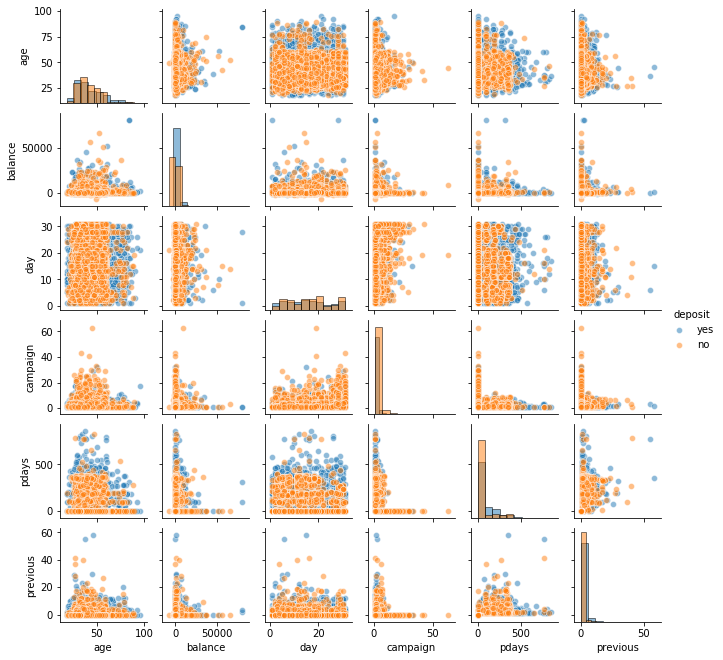

In [10]:
sns.pairplot(traindf, diag_kind='hist',  hue= 'deposit', height=1.5, 
             diag_kws={"edgecolor":"k", "alpha":0.5},
             plot_kws={"alpha":0.5})

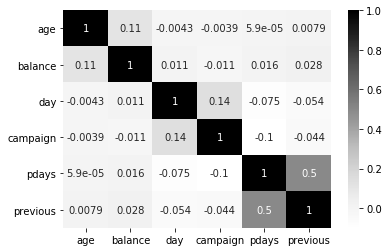

In [11]:
sns.heatmap(traindf.corr(method='pearson'), cmap="Greys", annot=True)

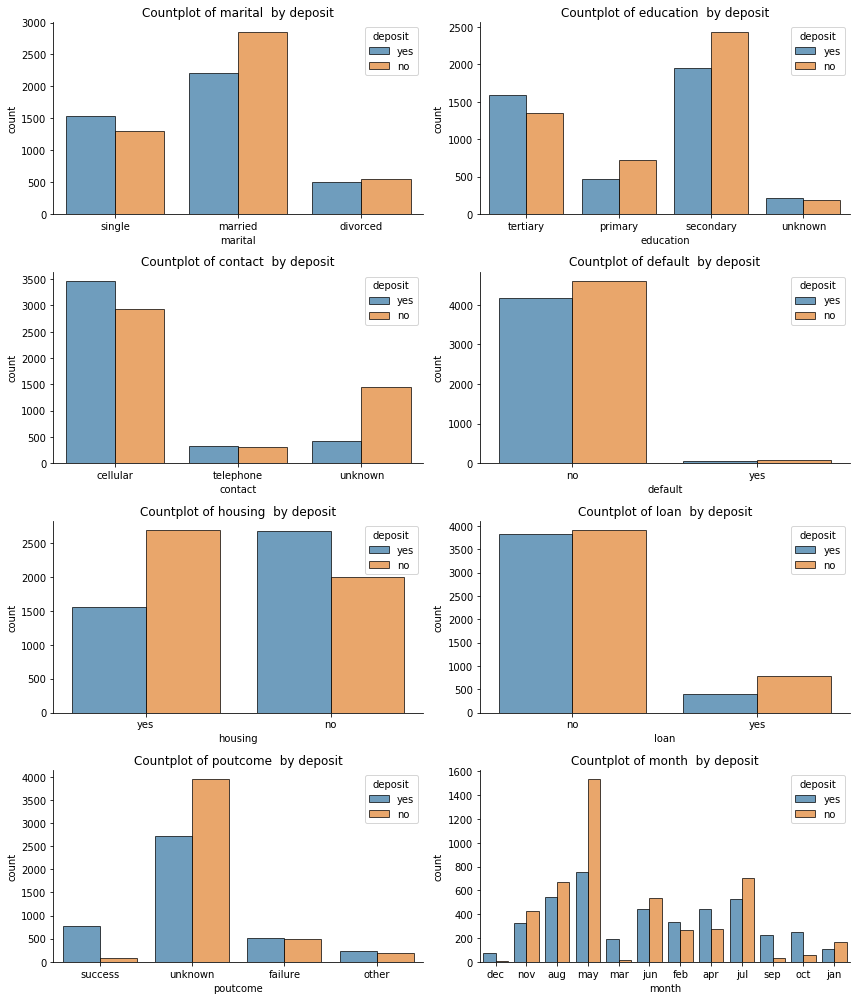

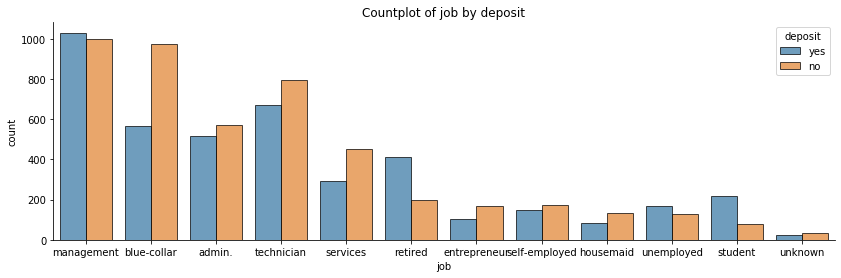

In [12]:
plt.figure(figsize=[12,14])
features=["marital", "education", "contact", "default", "housing", "loan", "poutcome", "month"]
n=1
for f in features:
    plt.subplot(4,2,n)
    sns.countplot(x=f, hue='deposit', edgecolor="black", alpha=0.7, data=traindf)
    sns.despine()
    plt.title("Countplot of {}  by deposit".format(f))
    n=n+1
plt.tight_layout()
plt.show()


    
plt.figure(figsize=[14,4])
sns.countplot(x='job', hue='deposit',edgecolor="black", alpha=0.7, data=traindf)
sns.despine()
plt.title("Countplot of job by deposit")
plt.show()

In [13]:
LE=LabelEncoder()
data['deposit']=LE.fit_transform(data.deposit.values)

#encoding categorical features
data=pd.get_dummies(data)

In [14]:
for train_index, test_index in sss.split(data.drop("deposit",axis=1), data.deposit):
    traindf=data.loc[train_index]
    testdf= data.loc[test_index]

In [15]:
xtrain=traindf.drop('deposit', axis=1)
ytrain=traindf.deposit

xtest=testdf.drop('deposit', axis=1)
ytest=testdf.deposit

In [16]:
pipe_knn= make_pipeline(StandardScaler(), KNeighborsClassifier())
 
# grid searh to choose the best (combination of) hyperparameters
gs_knn=GridSearchCV(estimator= pipe_knn,
               param_grid={'kneighborsclassifier__n_neighbors':[4,5,6,7]},
               scoring='accuracy',
               cv=10)

# nested cross validation combining grid search (inner loop) and k-fold cv (outter loop)
gs_knn_scores = cross_val_score(gs_knn, X=xtrain, y=ytrain, cv=5,scoring='accuracy', n_jobs=-1)

# fit, and fit with best estimator
gs_knn.fit(xtrain, ytrain)
gs_knn_best=gs_knn.best_estimator_
gs_knn_best.fit(xtrain, ytrain)

print('Train Accuracy:   {0:.1f}%'.format(gs_knn.score(xtrain, ytrain)*100))
print('CV Mean Accuracy: {0:.1f}%'.format(np.mean(gs_knn_scores)*100))
print('Test Accuracy:    {0:.1f}%'.format(gs_knn.score(xtest, ytest)*100))

Train Accuracy:   76.0%
CV Mean Accuracy: 68.8%
Test Accuracy:    68.5%


In [17]:
pipe_svm= make_pipeline(StandardScaler(), SVC(random_state=1))

# grid searh to choose the best (combination of) hyperparameters
r=[0.1,1,10]
pg_svm=[{'svc__C':r, 'svc__kernel':['linear']},
        {'svc__C':r, 'svc__gamma':r, 'svc__kernel':['rbf']}]

gs_svm=GridSearchCV(estimator= pipe_svm,
               param_grid= pg_svm,
               scoring='accuracy',
               cv=2)

# nested cross validation combining grid search (inner loop) and k-fold cv (outter loop)
gs_svm_scores = cross_val_score(gs_svm, X=xtrain, y=ytrain, cv=5,scoring='accuracy', n_jobs=-1)

# fit, and fit with best estimator
gs_svm.fit(xtrain, ytrain)
gs_svm_best=gs_svm.best_estimator_
gs_svm_best.fit(xtrain, ytrain)

print('Train Accuracy:   {0:.1f}%'.format(gs_svm.score(xtrain, ytrain)*100))
print('CV Mean Accuracy: {0:.1f}%'.format(np.mean(gs_svm_scores)*100))
print('Test Accuracy:    {0:.1f}%'.format(gs_svm.score(xtest, ytest)*100))

Train Accuracy:   85.3%
CV Mean Accuracy: 69.4%
Test Accuracy:    68.7%


In [18]:
rf= RandomForestClassifier(random_state=1)

# grid searh to choose the best (combination of) hyperparameters
pg_rf={'n_estimators': [100,200,400],'max_depth': [20,40,60]}

gs_rf=GridSearchCV(estimator= rf,
               param_grid= pg_rf,
               scoring='accuracy',
               cv=2)

# nested cross validation combining grid search (inner loop) and k-fold cv (outter loop)
gs_rf_scores = cross_val_score(gs_rf, X=xtrain, y=ytrain, cv=5,scoring='accuracy', n_jobs=-1)

# fit, and fit with best estimator
gs_rf.fit(xtrain, ytrain)
gs_rf_best=gs_rf.best_estimator_
gs_rf_best.fit(xtrain, ytrain)

print('Train Accuracy:   {0:.1f}%'.format(gs_rf.score(xtrain, ytrain)*100))
print('CV Mean Accuracy: {0:.1f}%'.format(np.mean(gs_rf_scores)*100))
print('Test Accuracy:    {0:.1f}%'.format(gs_rf.score(xtest, ytest)*100))

Train Accuracy:   97.4%
CV Mean Accuracy: 72.9%
Test Accuracy:    72.9%


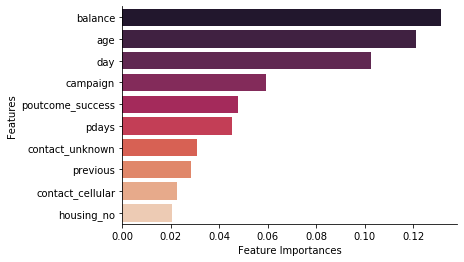

In [21]:
importances= gs_rf_best.feature_importances_
feature_importances= pd.Series(importances, index=xtrain.columns).sort_values(ascending=False)
sns.barplot(x=feature_importances[0:10], y=feature_importances.index[0:10], palette="rocket")
sns.despine()
plt.xlabel("Feature Importances")
plt.ylabel("Features")
plt.show()

###  EDA

In [7]:
data=pd.read_csv('bank.csv')
data.head(2)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes


Text(0.5, 1.0, 'Distribution of age')

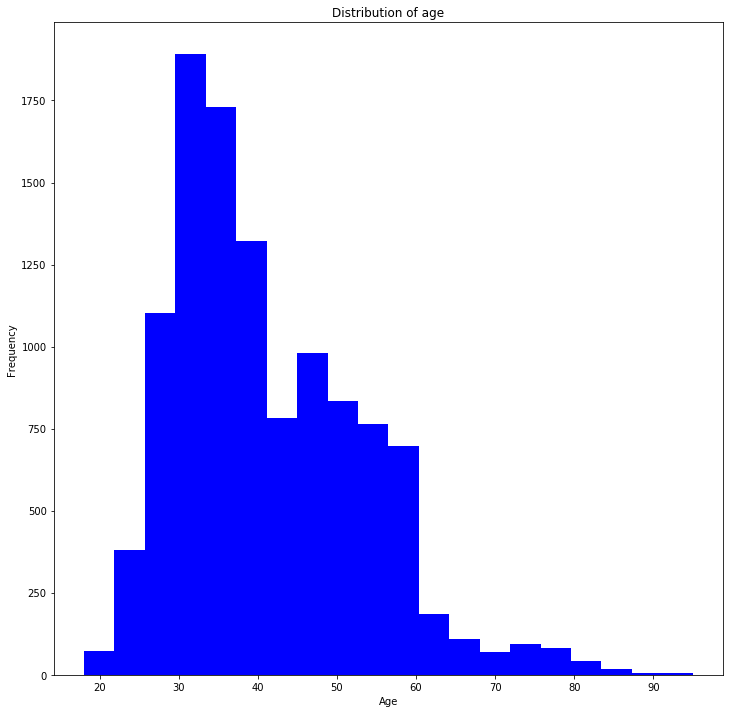

In [8]:
plt.figure(figsize=[12,12])
plt.hist(data['age'],bins=20,color='b')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of age')

Text(0.5, 1.0, 'Distribution of balance')

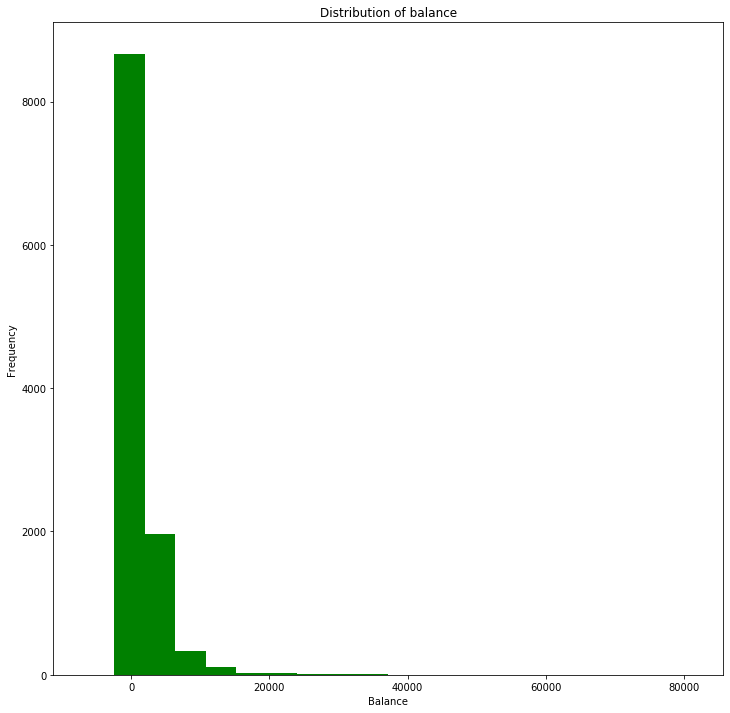

In [10]:
plt.figure(figsize=[12,12])
plt.hist(data['balance'],bins=20,color='green')
plt.xlabel('Balance')
plt.ylabel('Frequency')
plt.title('Distribution of balance')

Text(0.5, 1.0, 'Distribution of Day on which customer arrived')

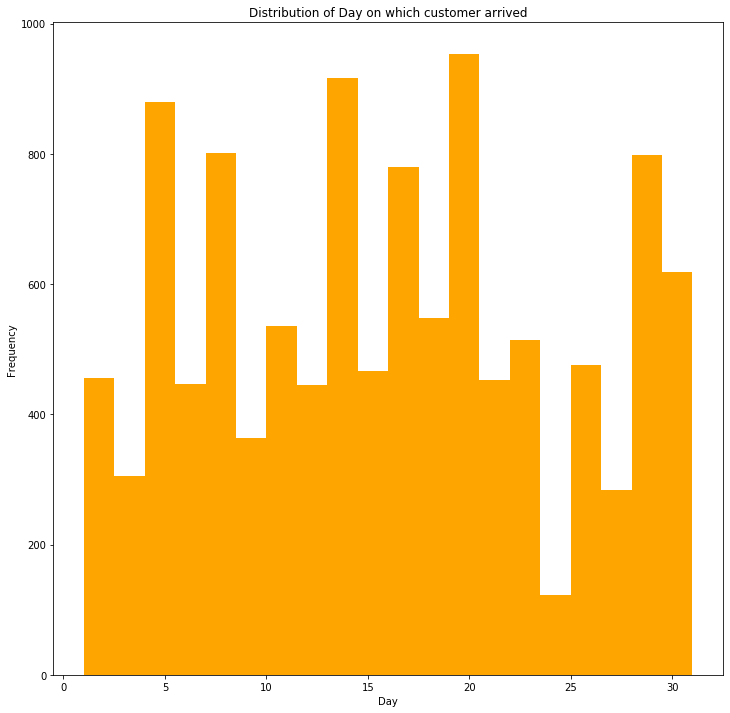

In [11]:
plt.figure(figsize=[12,12])
plt.hist(data['day'],bins=20,color='orange')
plt.xlabel('Day')
plt.ylabel('Frequency')
plt.title('Distribution of Day on which customer arrived')

Text(0.5, 1.0, 'Distribution of Duration')

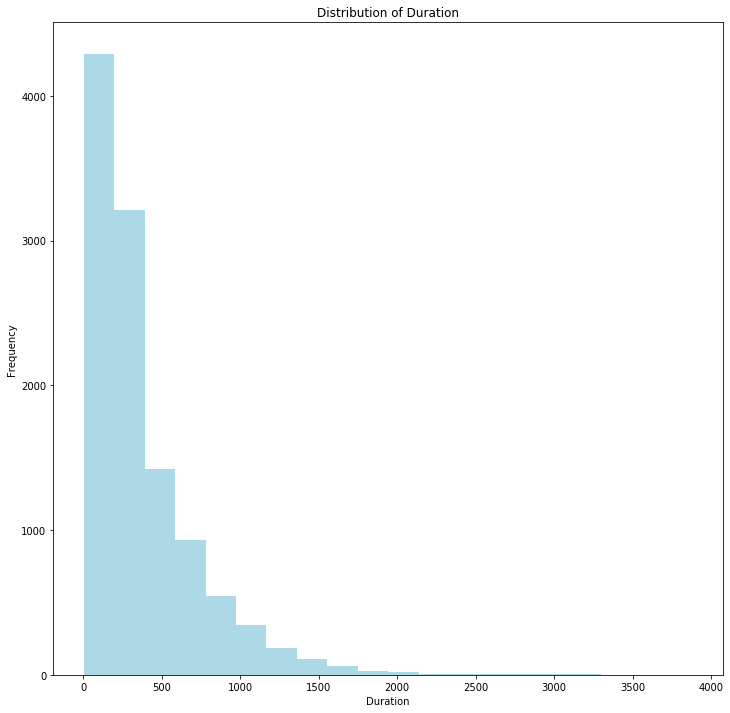

In [12]:
plt.figure(figsize=[12,12])
plt.hist(data['duration'],bins=20,color='lightblue')
plt.xlabel('Duration')
plt.ylabel('Frequency')
plt.title('Distribution of Duration')

In [15]:
def bar_plot(variable):
    #get feature
    var = data[variable]
    #count number of categorical variable(value/sample)
    varValue = var.value_counts()
   
    #visualize
    plt.figure(figsize = (20,12))
    plt.bar(varValue.index, varValue)
    plt.xticks(varValue.index, varValue.index.values)
    plt.ylabel("Frequency")
    plt.title(variable)
    plt.show()
    print("{}: \n {}".format(variable, varValue))

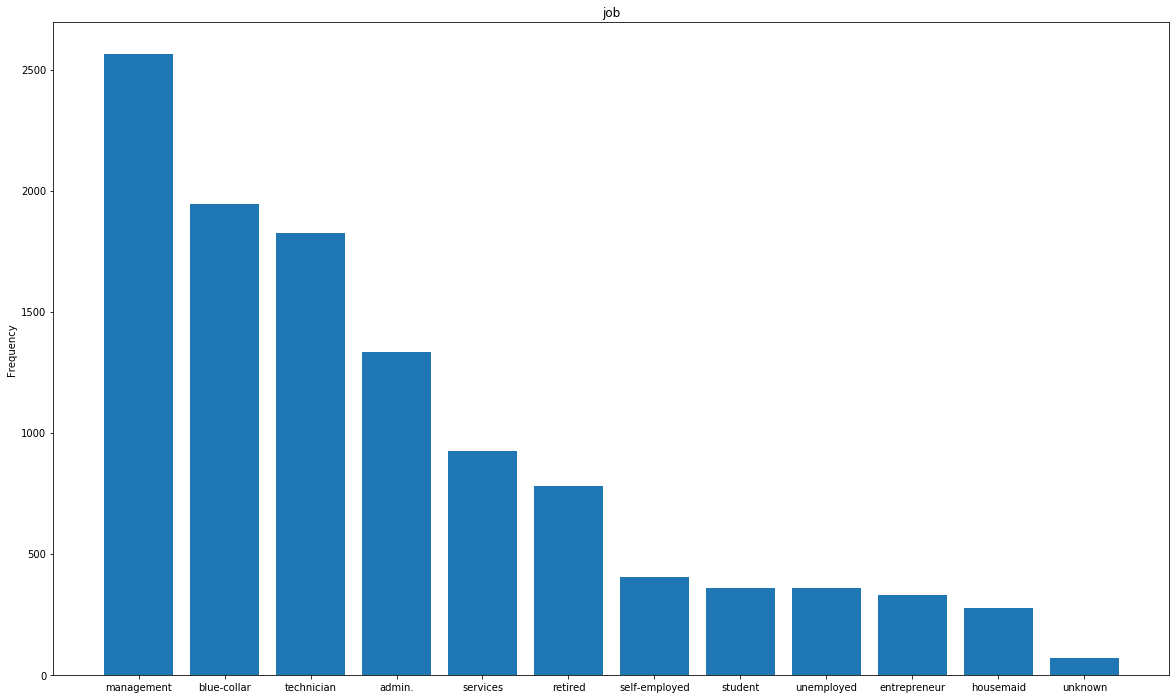

job: 
 management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64


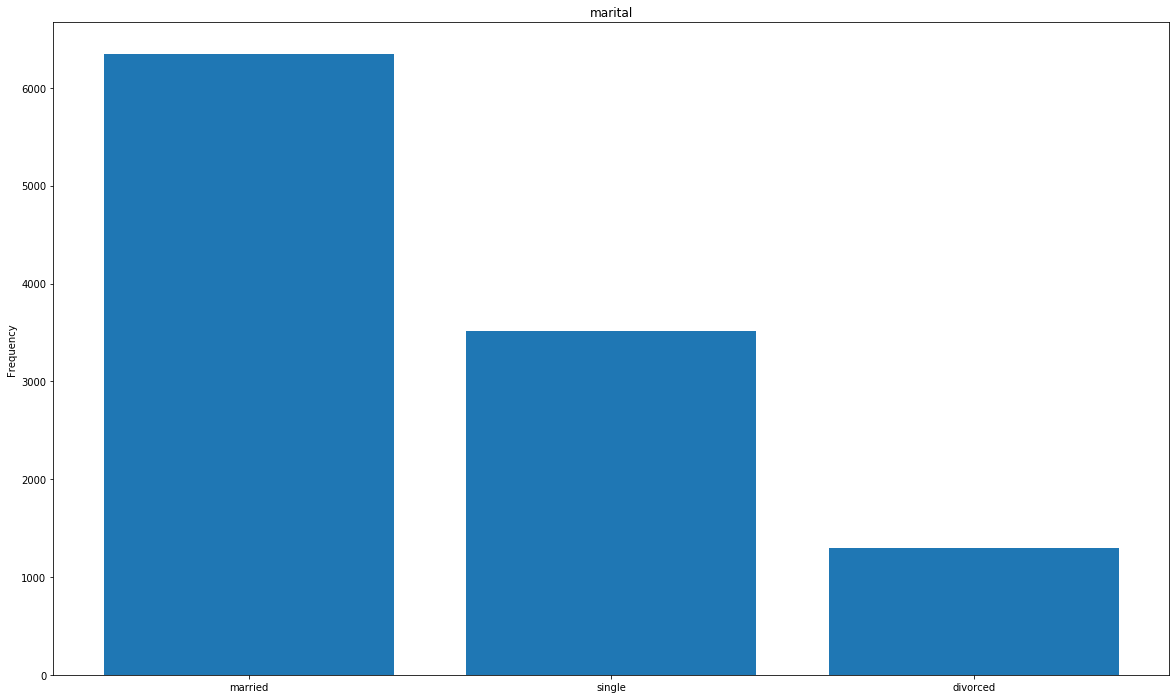

marital: 
 married     6351
single      3518
divorced    1293
Name: marital, dtype: int64


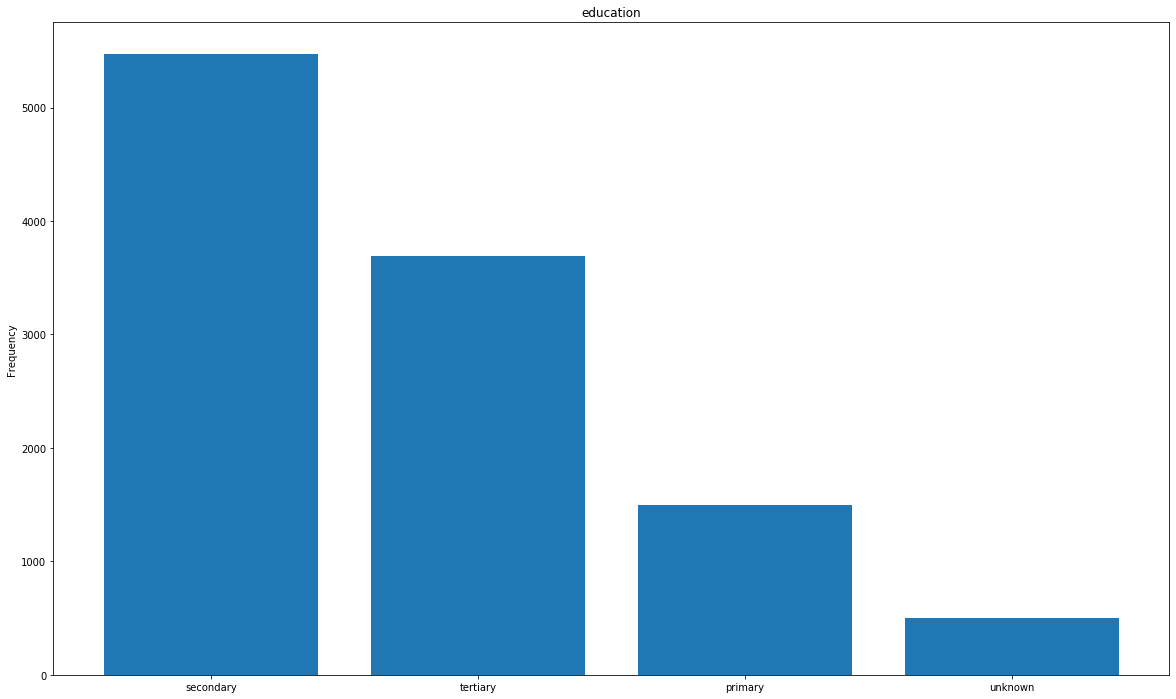

education: 
 secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: education, dtype: int64


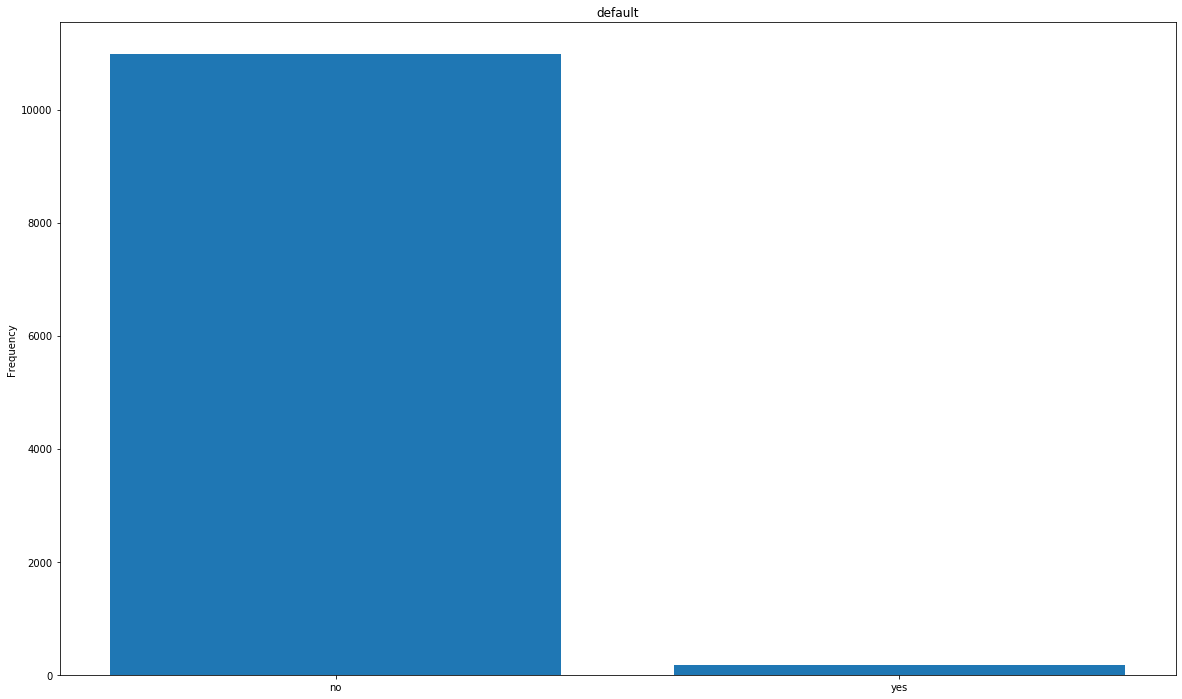

default: 
 no     10994
yes      168
Name: default, dtype: int64


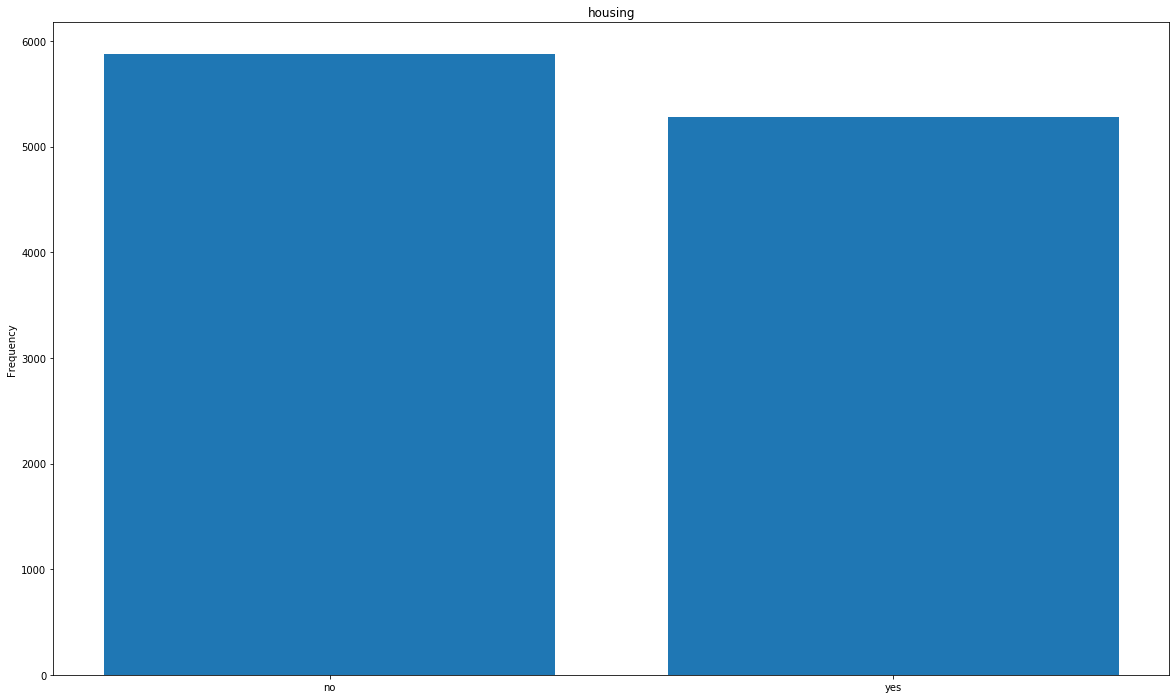

housing: 
 no     5881
yes    5281
Name: housing, dtype: int64


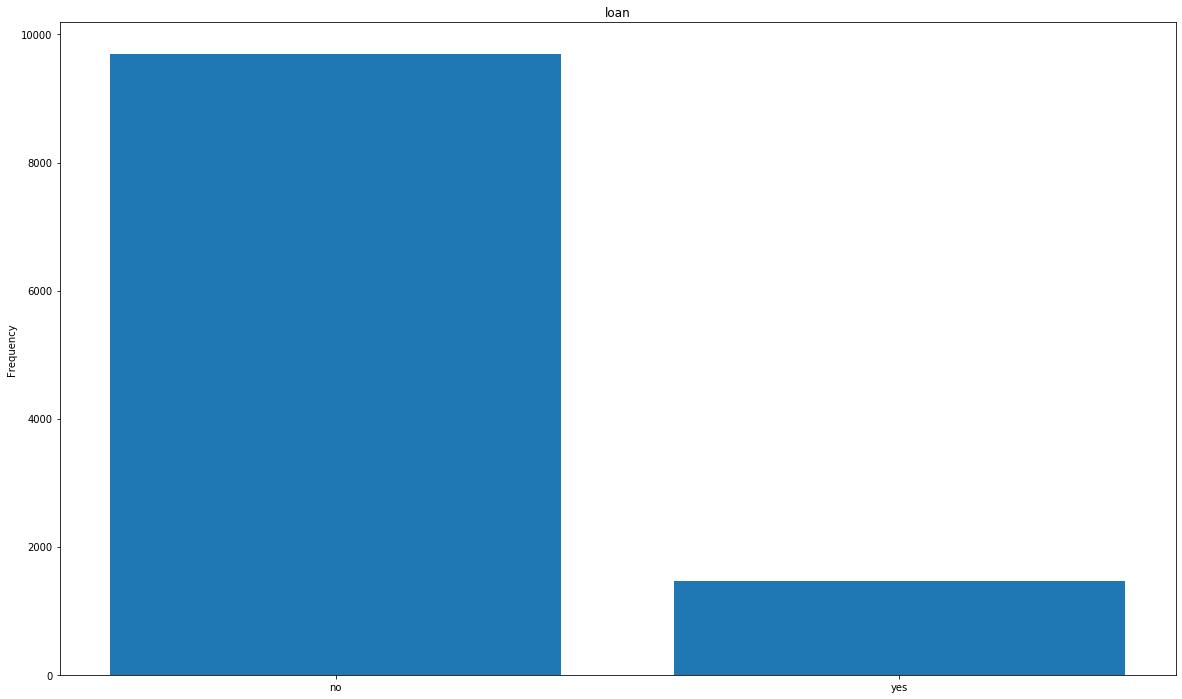

loan: 
 no     9702
yes    1460
Name: loan, dtype: int64


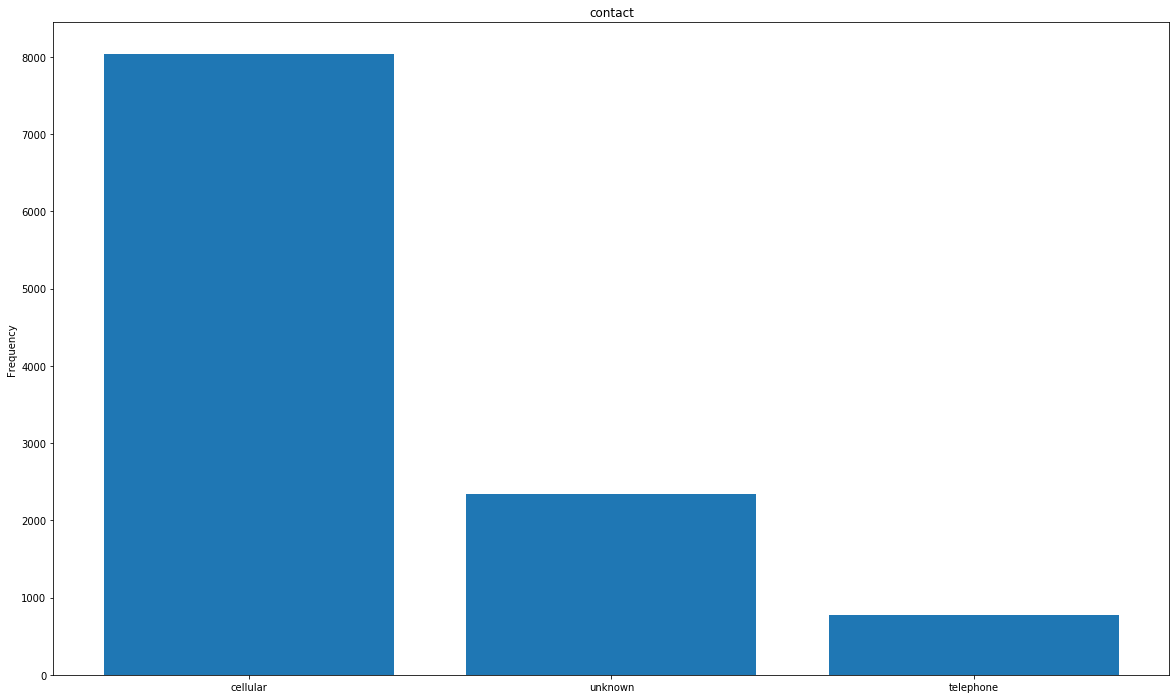

contact: 
 cellular     8042
unknown      2346
telephone     774
Name: contact, dtype: int64


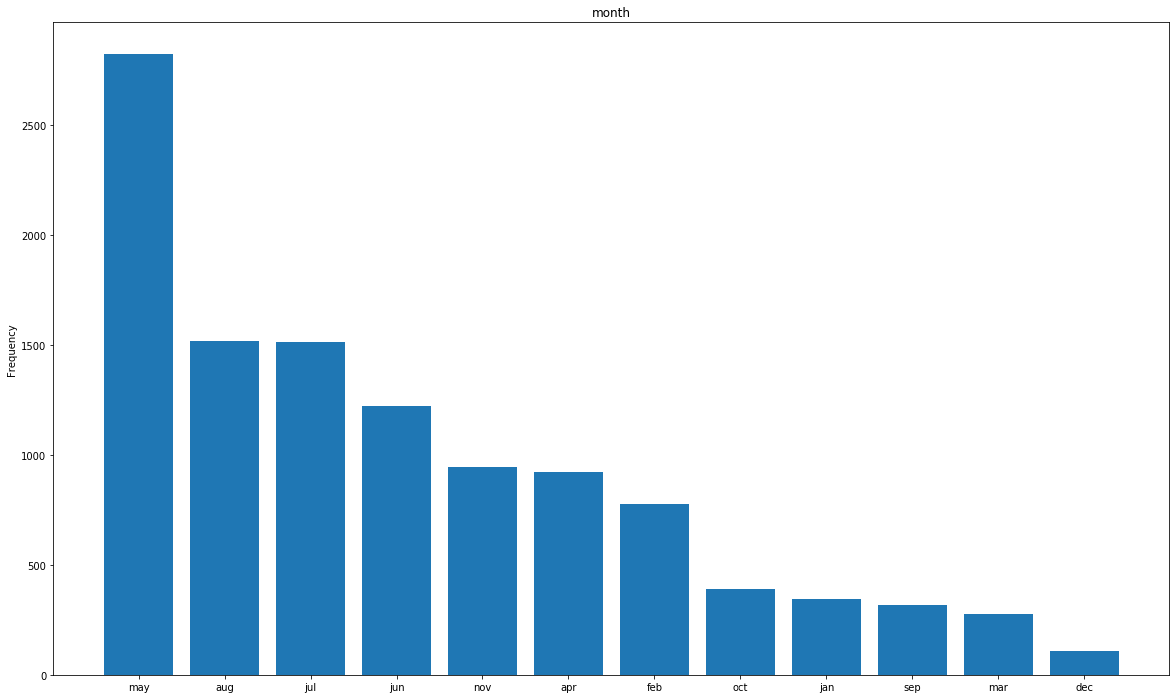

month: 
 may    2824
aug    1519
jul    1514
jun    1222
nov     943
apr     923
feb     776
oct     392
jan     344
sep     319
mar     276
dec     110
Name: month, dtype: int64


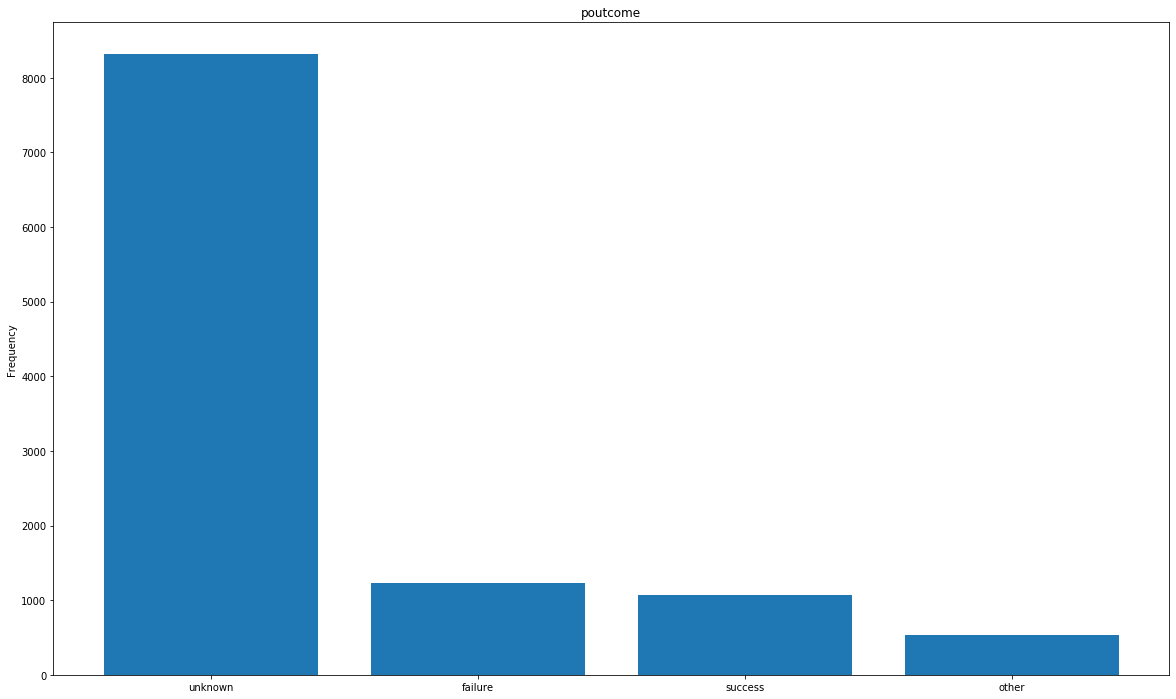

poutcome: 
 unknown    8326
failure    1228
success    1071
other       537
Name: poutcome, dtype: int64


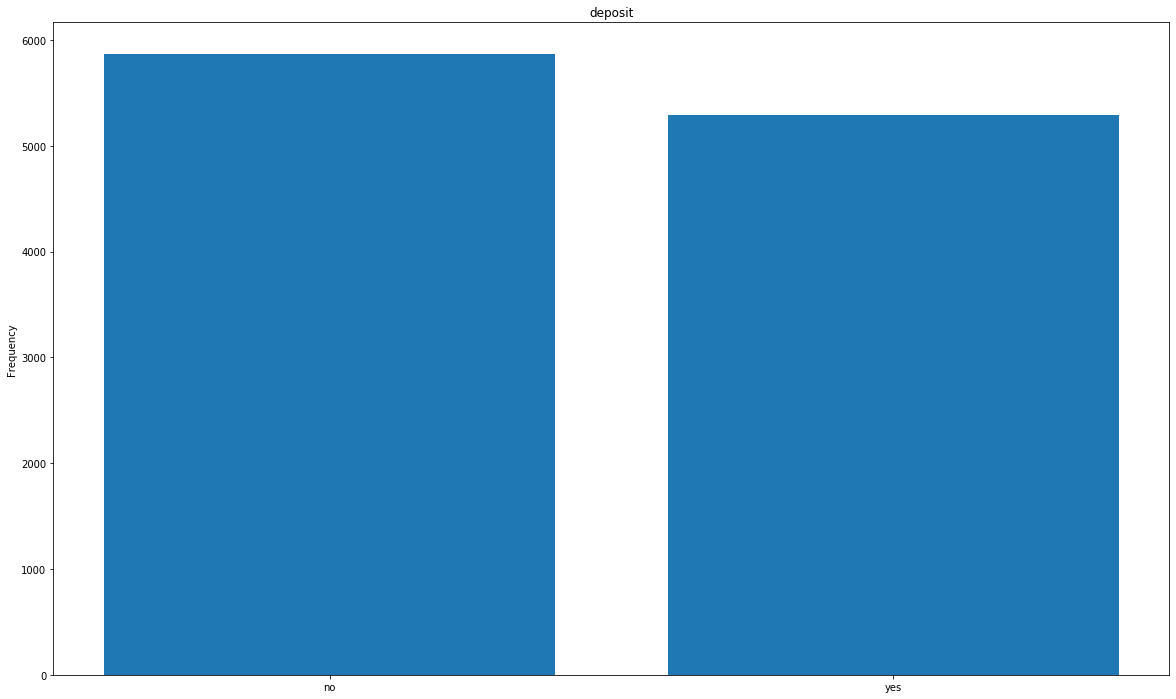

deposit: 
 no     5873
yes    5289
Name: deposit, dtype: int64


In [16]:
category1 = ["job","marital","education","default","housing","loan","contact","month","poutcome","deposit"]
for c in category1:
    bar_plot(c)

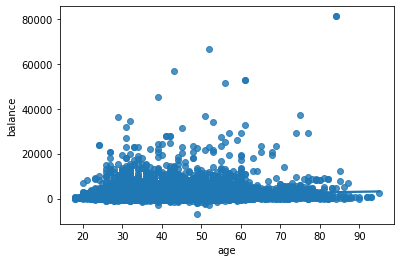

In [18]:
sns.regplot(x='age',y='balance',data=data)

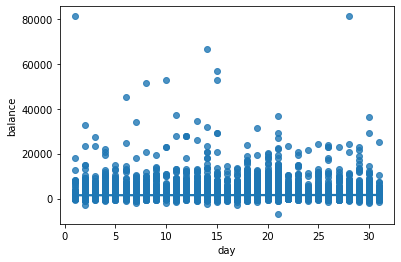

In [19]:
sns.regplot(x='day',y='balance',data=data)

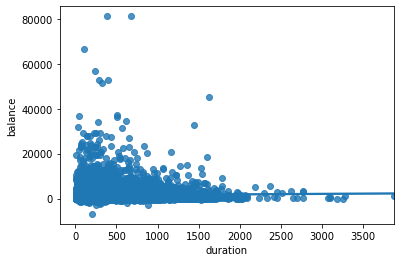

In [20]:
sns.regplot(x='duration',y='balance',data=data)

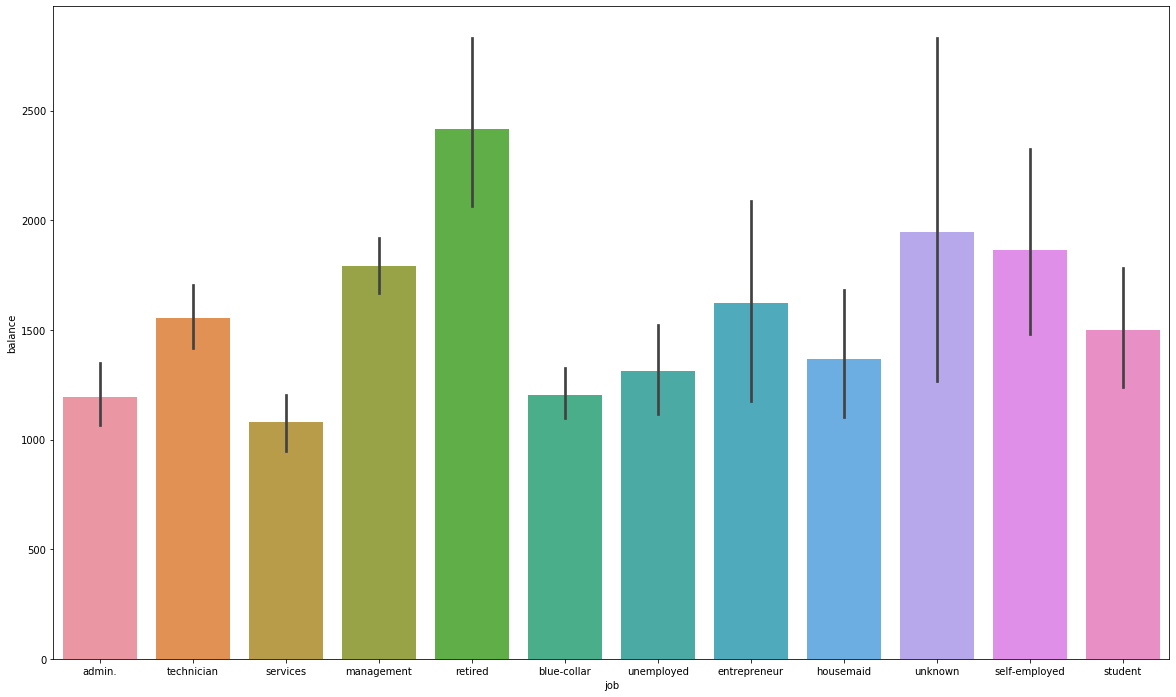

In [23]:
plt.figure(figsize = (20,12))
sns.barplot(x='job',y='balance',data=data)
plt.show()

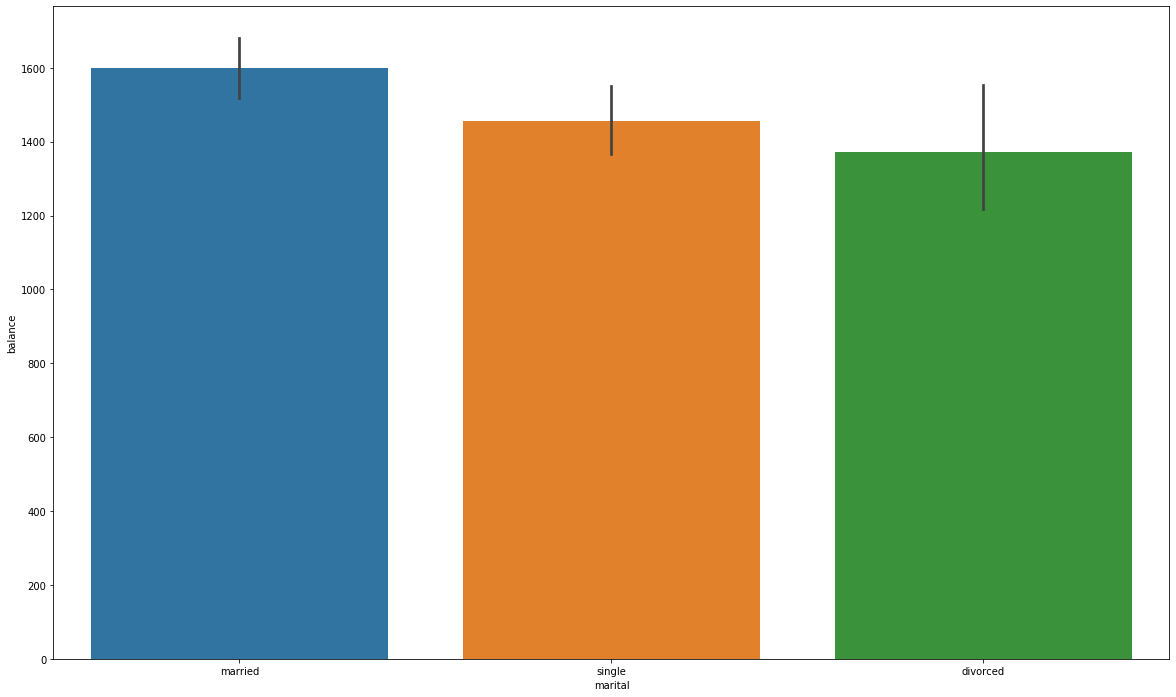

In [24]:
plt.figure(figsize = (20,12))
sns.barplot(x='marital',y='balance',data=data)
plt.show()

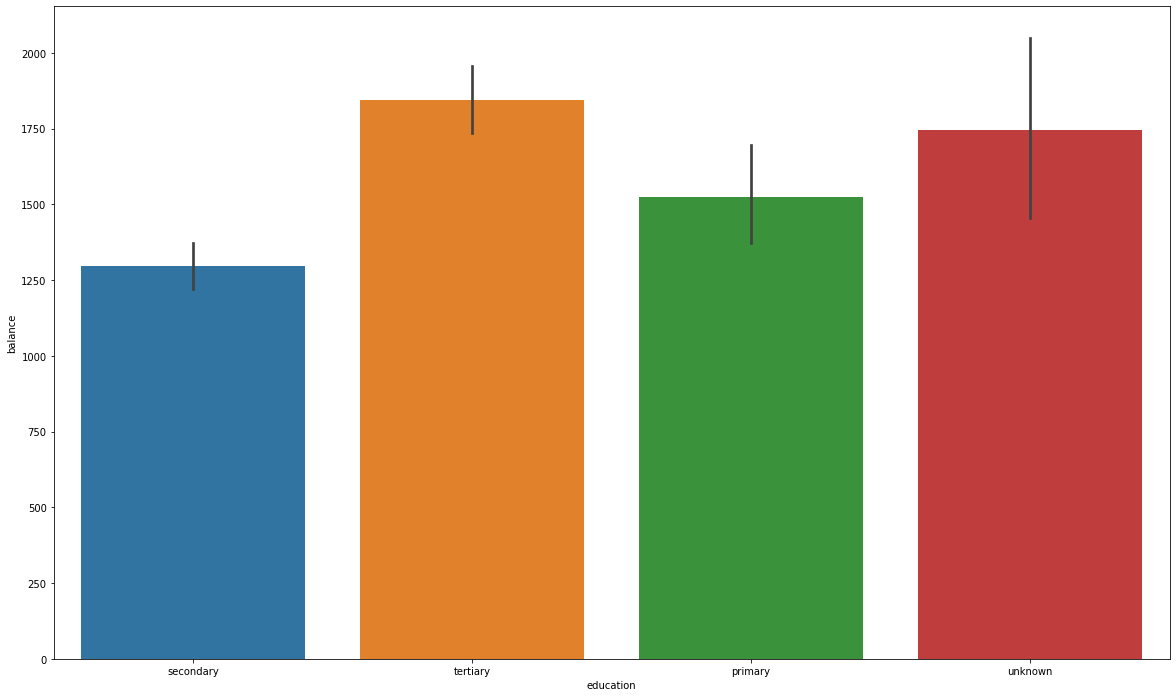

In [25]:
plt.figure(figsize = (20,12))
sns.barplot(x='education',y='balance',data=data)
plt.show()

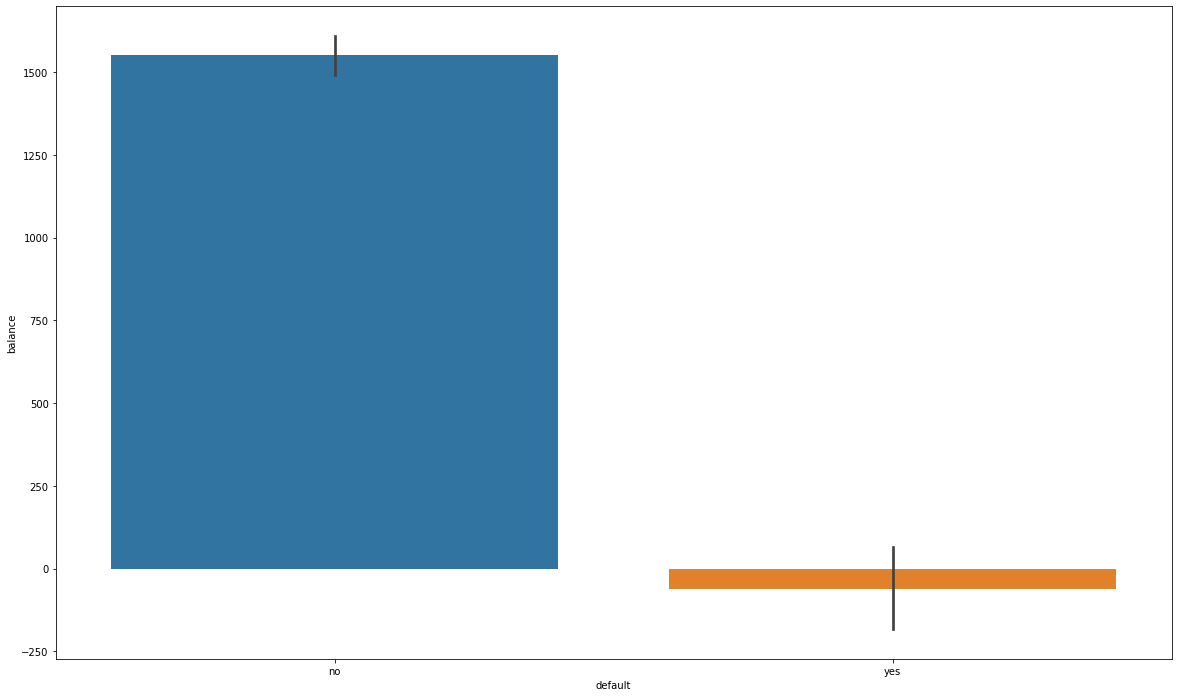

In [26]:
plt.figure(figsize = (20,12))
sns.barplot(x='default',y='balance',data=data)
plt.show()

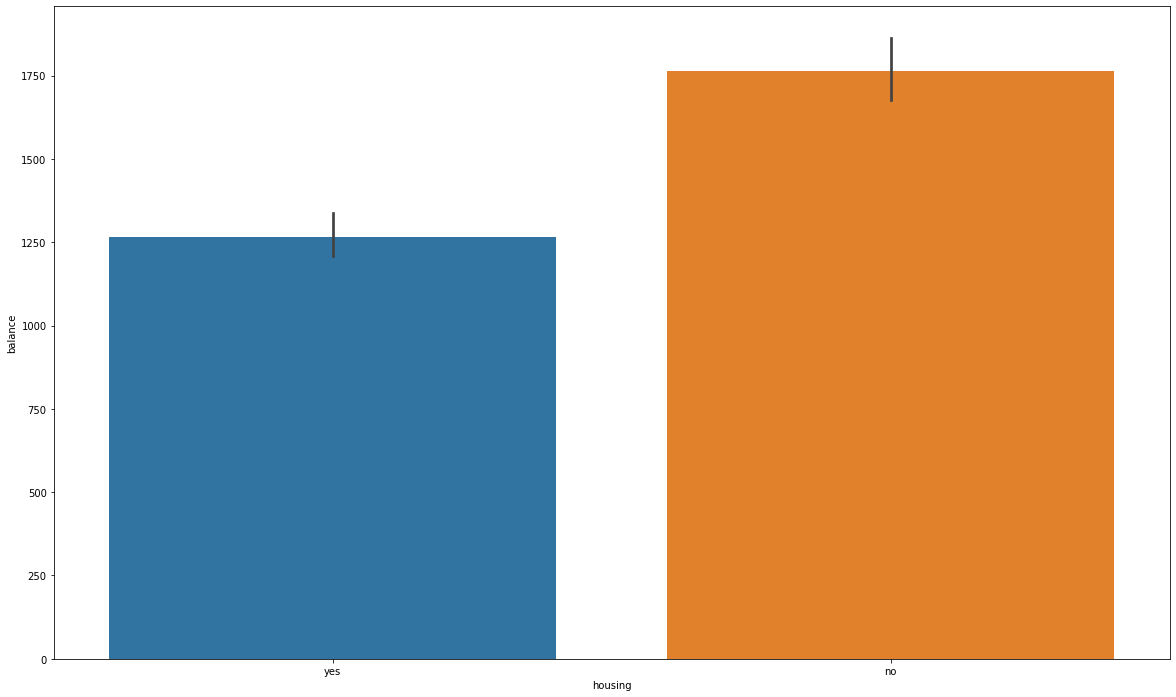

In [27]:
plt.figure(figsize = (20,12))
sns.barplot(x='housing',y='balance',data=data)
plt.show()

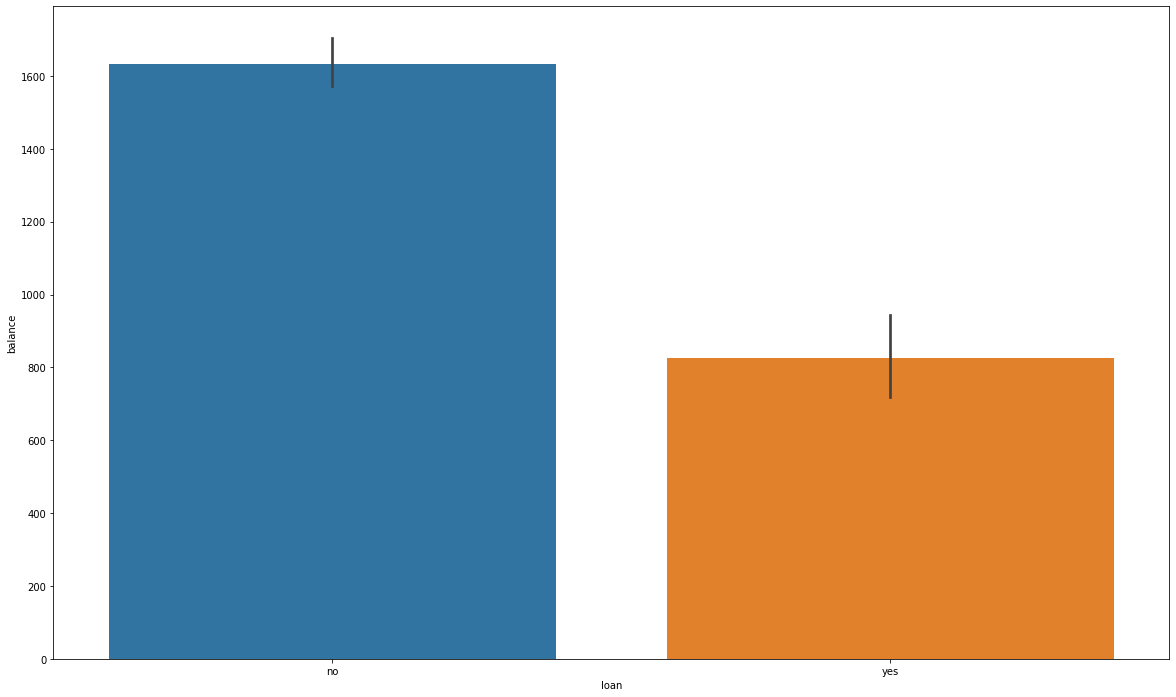

In [28]:
plt.figure(figsize = (20,12))
sns.barplot(x='loan',y='balance',data=data)
plt.show()

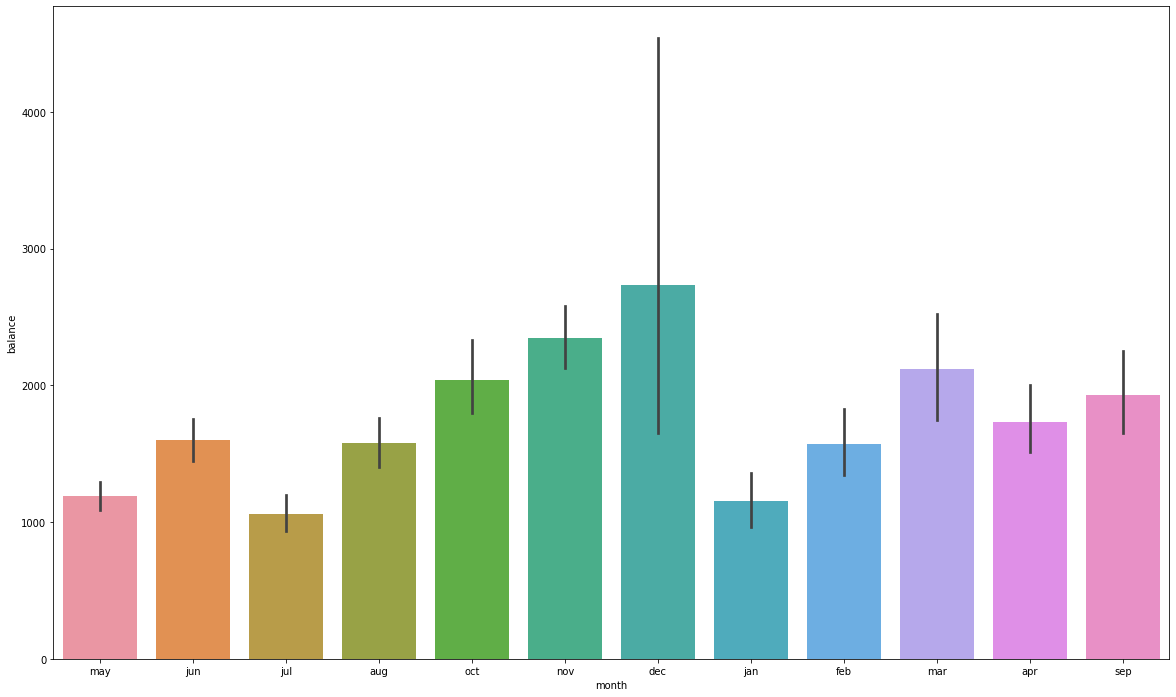

In [29]:
plt.figure(figsize = (20,12))
sns.barplot(x='month',y='balance',data=data)
plt.show()

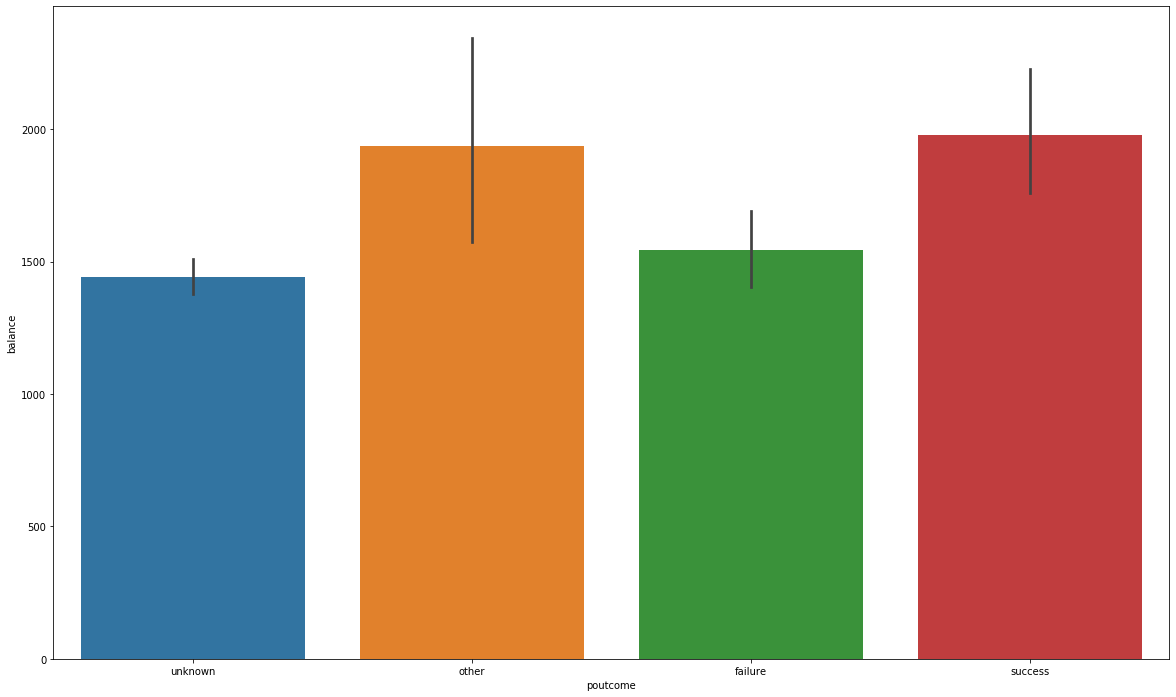

In [30]:
plt.figure(figsize = (20,12))
sns.barplot(x='poutcome',y='balance',data=data)
plt.show()

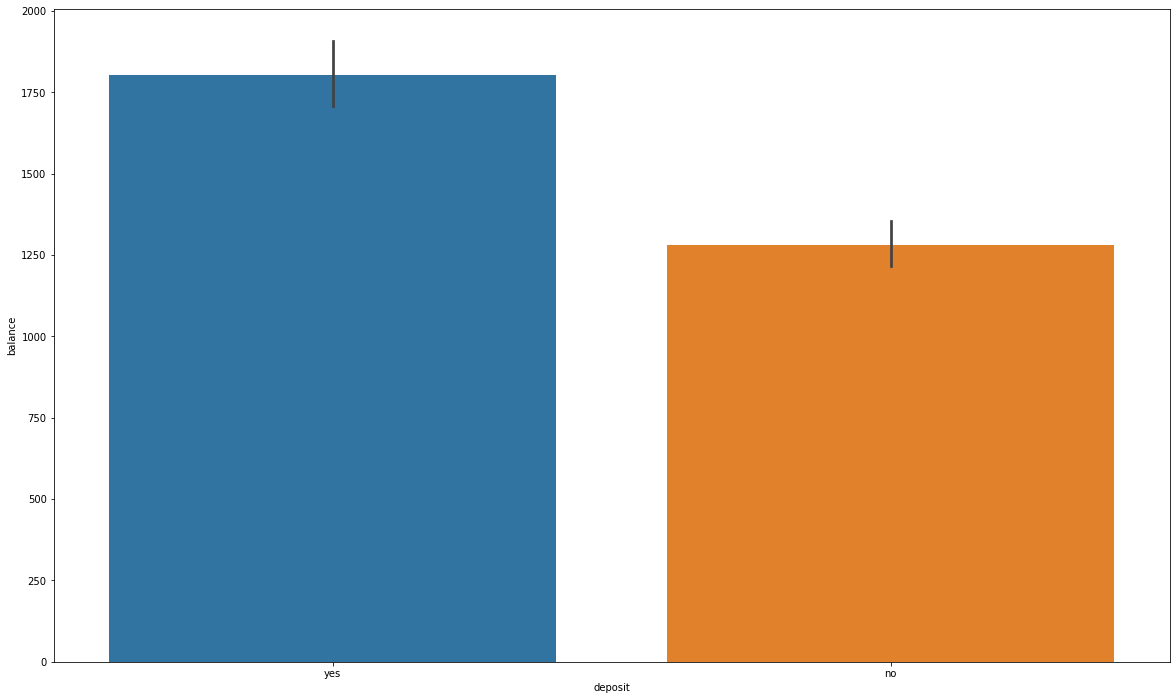

In [31]:
plt.figure(figsize = (20,12))
sns.barplot(x='deposit',y='balance',data=data)
plt.show()

In [33]:
gr=sns.FacetGrid(data, col="poutcome", row="job", size=20)
gr.map(plt.hist, "balance", bins=25)
gr.add_legend()
plt.show()